# Introduction

Small accidents that could be easily covered by local health insurance plans may end up being a huge financial burden when occured abroad. Travel insurances stand as a safety net to avoid this kind of situations. 

As an insurance agency, we want to reach as many people as possible. However, in order to reduce our advertisement costs, we want to reach exactly those who would want to buy an insurance. In this project, we will try to identify individiuals who are likely to get a travel insurance. We will train a machine learning model to automatically mark those individuals and direct our advertisement efforts to these people. 

The current problem is that we do not know the characteristics of the people who are likely to buy a travel insurance. As we do not know those people, our advertisements tend to miss the mark when trying to reach these people. This leads to unnecessary costs, and unrewarded efforts. In order to fix this, we will use the help of machine learning models.

We want to reach as many individuals who would buy an insurance, but we don't mind reaching others every now and then accidently. In order to measure, how successful our model is at this task, we will use the metric called recall. Recall measures the model's ability of correctly identifying individiuals who bought an insurance out of all people who bought an insurance. For example, if we have 100 people who bought an insurance, and our model was able to detect 70 individuals of this group correctly, this returns a recall score of 0.70. Please note that this does not take into account the individuals who did not buy an insurance, but labeled as a buyer anyway. As said before, we do not mind reaching extra people as long as we reach our audience. 

After the model is trained, it will be ready to help us to target individuals with ads. As we will limit the number of the ads to these people, our advertisement costs will decrease. This is the main benefit we are looking to gain from this project.

# Methodology

In this project, several different python libraries were used to aid us with our objective.

- Pandas
- Numpy
- Matplotlib
- Seaborn
- Scikit Learn
- Statsmodels

In order view and wrangle data, we used Pandas and Numpy libraries. These were essential in order to extract insights from the data, and in order to prepare the data to be ready to fed into machine learning models. Other libraries to gain insight were used. Matplotlib and seaborn helped us to visualize the data to see the content in a more human readable format. In order to conduct hypothesis tests, we used z-tests provided by the statsmodels library. Finally, machine learning models and the tools to prepare the data were used from the scikit learn library.

# Data Preparation

In [368]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [369]:
import warnings
warnings.filterwarnings('ignore')

In [370]:
travel = pd.read_csv('TravelInsurancePrediction.csv')
travel.head()

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


### Duplicate Values

In [371]:
travel.duplicated().sum()

0

There are no duplicate rows in this dataset.

### Missing Values and Data Types

In [372]:
travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           1987 non-null   int64 
 1   Age                  1987 non-null   int64 
 2   Employment Type      1987 non-null   object
 3   GraduateOrNot        1987 non-null   object
 4   AnnualIncome         1987 non-null   int64 
 5   FamilyMembers        1987 non-null   int64 
 6   ChronicDiseases      1987 non-null   int64 
 7   FrequentFlyer        1987 non-null   object
 8   EverTravelledAbroad  1987 non-null   object
 9   TravelInsurance      1987 non-null   int64 
dtypes: int64(6), object(4)
memory usage: 155.4+ KB


In [373]:
travel['ChronicDiseases'] = travel['ChronicDiseases'].astype('object')

### Outliers

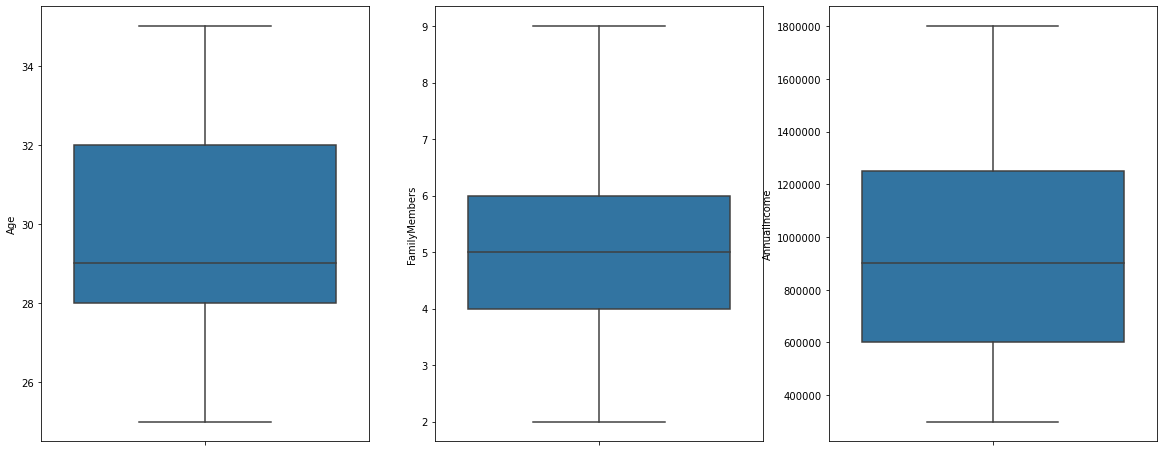

In [374]:
fig, ax = plt.subplots(1, 3, figsize=(20,8))
sns.boxplot(y='Age', data=travel, ax=ax[0])
sns.boxplot(y='FamilyMembers', data=travel, ax=ax[1])
sns.boxplot(y='AnnualIncome', data=travel, ax=ax[2])
plt.ticklabel_format(style='plain', axis='y')

All numeric columns are in the expected ranges.

### Data Split

In [375]:
X = travel.drop(['TravelInsurance', 'Unnamed: 0'], axis=1)
y = travel['TravelInsurance']

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [377]:
travel_train = X_train.merge(y_train, right_index=True, left_index=True)

# Data Analysis

## Travelers

Before starting to train a model to find a solution to our problem, we will try to understand the dataset and gain insight. Firstly, let's take a look at how people in this dataset have different traveling preferences. We will first look at how many people in the dataset gets insurance for their travels.

In [378]:
positions = ['top', 'left', 'right']
def turn_spines_off(ax, positions=positions):
  for i in positions:
    ax.spines[i].set_visible(False)

In [379]:
def count_plots(x_col,  tick_labels, hue_col=None, title=''):
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.countplot(x=x_col, data=travel_train, ax=ax, hue=hue_col)
    plt.suptitle(title, fontsize=20)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks([])
    ax.set_ylabel('Number of Individuals', fontsize=15)
    ax.set_xlabel(x_col, fontsize=15)
    turn_spines_off(ax)
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], padding=-30, fontsize=20, color='white')
        
    plt.show()

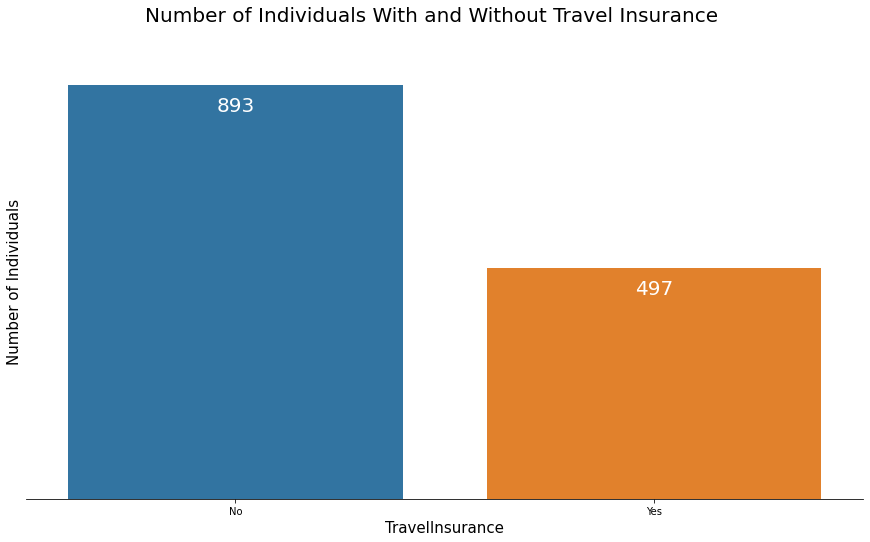

In [380]:
count_plots(x_col='TravelInsurance',
            title='Number of Individuals With and Without Travel Insurance', tick_labels=['No', 'Yes'])

While most people decided not to buy a travel insurance, we see that those who have an insurance are not too far behind. In our case, we should be finding similar cases and target those people who would want to buy insurance. In order to find these demographics, we will take a closer look at the dataset.

Let's see how many of the people in our dataset are frequent travelers, and out of these people we want to see how many of them have insurance. These people could be more interesed in a travel insurance as they are the people who would most benefit from it.

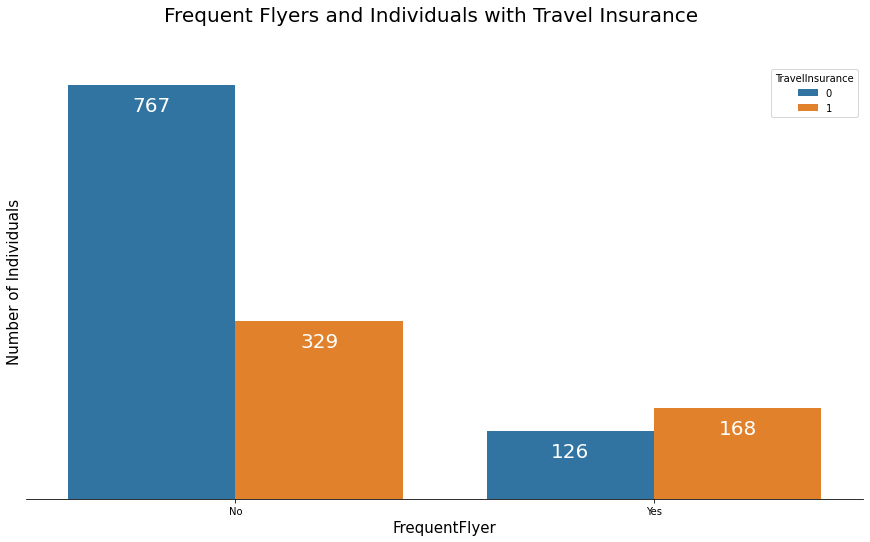

In [446]:
count_plots('FrequentFlyer', hue_col='TravelInsurance',
           title='Frequent Flyers and Individuals with Travel Insurance', tick_labels=['No', 'Yes'])

As expected, most people are not frequent flyers. Those who travel frequently consitute a minority of around 290 individuals. This is a stark contrast to those who are not frequent travelers, which are the majority with over a thousand people. 

An interesting thing to note here is that, more than half of the frequent flyers have travel insurance. The difference is not really strong, however, these people could still be a prime target for our case. 

On the other hand, we see that the majority of the people who do not travel frequently, does not have an insurance. However, there are still a lot of people from this demographic that opted to buy insurance. We need to investigate further to understand this.

Let's now look at those who traveled abroad and see how many of them decided to buy insurance. 

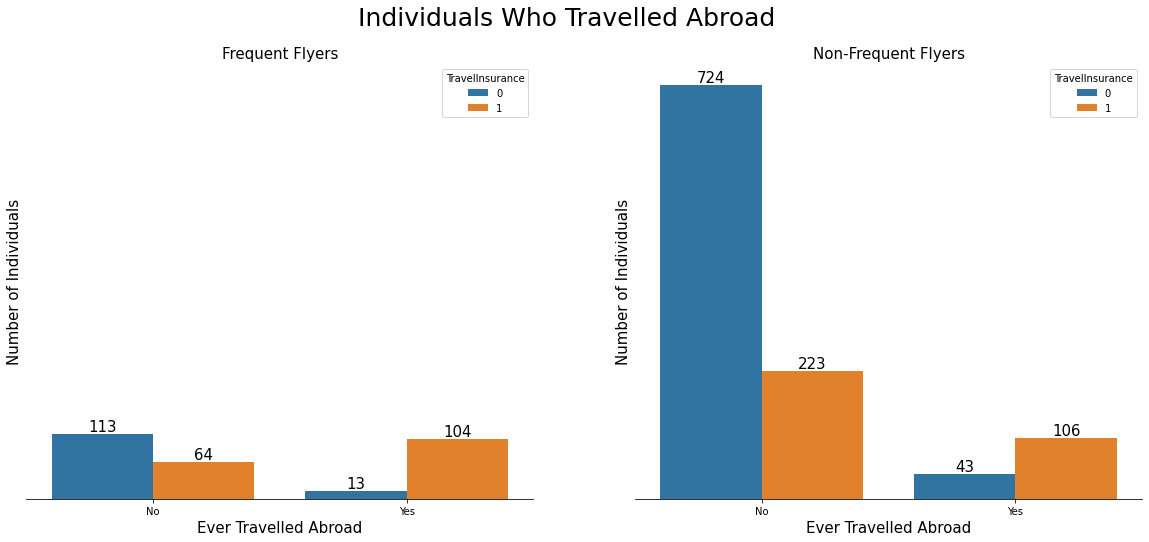

In [382]:
frequent_flyer = travel_train['FrequentFlyer'] == 'Yes'

fig, ax = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
sns.countplot(x='EverTravelledAbroad', data=travel_train[frequent_flyer], hue='TravelInsurance', ax=ax[0])
sns.countplot(x='EverTravelledAbroad', data=travel_train[~frequent_flyer], hue='TravelInsurance', ax=ax[1])
plt.suptitle('Individuals Who Travelled Abroad', fontsize=25)
for i in ax:
    for j in i.containers:
        i.bar_label(j, fontsize=15)
for i in range(len(ax)):
    ax[i].set_xticklabels(['No', 'Yes'])
    ax[i].set_yticks([])
    ax[i].set_ylabel('Number of Individuals', fontsize=15)
    ax[i].set_xlabel('Ever Travelled Abroad', fontsize=15)
    
ax[0].set_title('Frequent Flyers', fontsize=15)
ax[1].set_title('Non-Frequent Flyers', fontsize=15)

turn_spines_off(ax[0])
turn_spines_off(ax[1])
        
plt.show()

At first glance, we see that there are less people who traveled abroad at least once than those who has never traveled abroad before. Out of the group who have traveled abroad, we see that the clear majority had travel insurance. When we look at the subgroups of those who traveled abroad and those who are frequent flyers, we see that this group is insured at overwhelming rates. 104 individuals of this group were insured, while only 13 of them were uninsured. This shows us a very clear picture. People who travel abroad and travel often are the most likely group to buy insurance. 

On the other hand, when we checked people who traveled abroad, but were not frequent flyers, we still see that that people who chose to buy an insurance were the majority. 

It looks like having traveled abroad is a good indicator at determining whether an individual is likely to get insurance. 

Oftentimes traveling abroad is expensive. At this point, we want to understand, whether those who traveled abroad are well-off. This could be an important insight for us, as we know that most people who traveled abroad tend to buy insurance. Let's look at the income levels in our dataset to understand this aspect better.

## Income

In this dataset, the income levels are given in Indian rupees. In order to adopt to our own situation, and gain a better insight, we will convert these values to Euro. After this step, we will look at the distribution to understand how different income levels are present in our dataset.

In [383]:
travel_train['AnnualIncome_Euro'] = travel_train['AnnualIncome'] * 0.013

In [384]:
def dist_plots(x_col, bins=15):
    fig, ax = plt.subplots(figsize=(15, 8))
    turn_spines_off(ax)
    sns.histplot(x=x_col, data=travel_train, ax=ax, bins=bins)
    plt.axvline(x=travel_train[x_col].mean(),
            color='red')
    plt.title(f"Distribution of {x_col}", fontsize=20)
    plt.ylabel('Number of Individuals', fontsize=15)
    plt.xlabel(x_col, fontsize=15)
    plt.show()

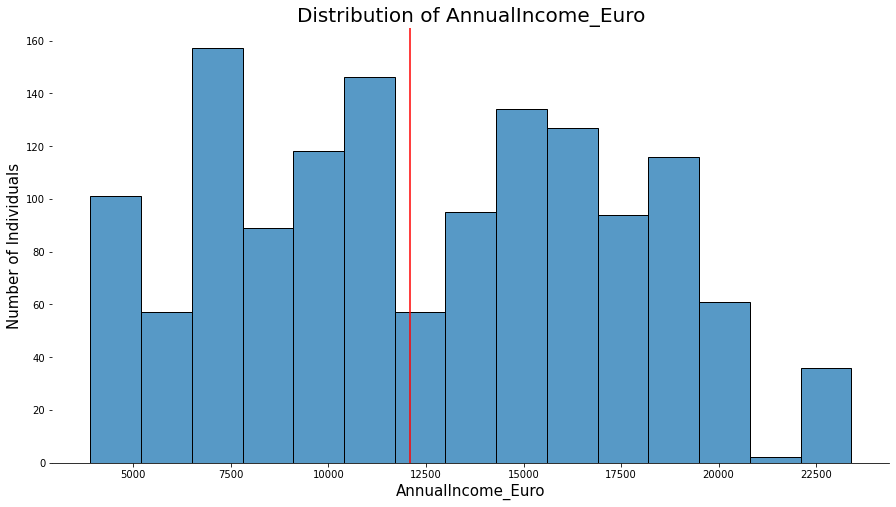

In [385]:
dist_plots('AnnualIncome_Euro')

Average annual income in India is around 2200 Euros. It looks like our dataset comes from a relatively richer demographic. Mean income of the individuals from our dataset is around 12000 Euros. Also, it is easy to see that there are different subgroups of wealth in this group. Some individual seem to make much more than others. Are people who have travel insurance richer than others? Let's find this out.

In [386]:
def bar_compare(x, y, tick_labels, title):
    fig, ax = plt.subplots(figsize=(15,8))
    sns.barplot(x=x, y=y, data=travel_train, ax=ax)
    plt.suptitle(title, fontsize=20)
    ax.set_xticklabels(tick_labels)
    ax.set_yticks([])
    ax.set_ylabel(y, fontsize=15)
    ax.set_xlabel(x, fontsize=15)
    turn_spines_off(ax)
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], padding=-30, fontsize=20, color='white')

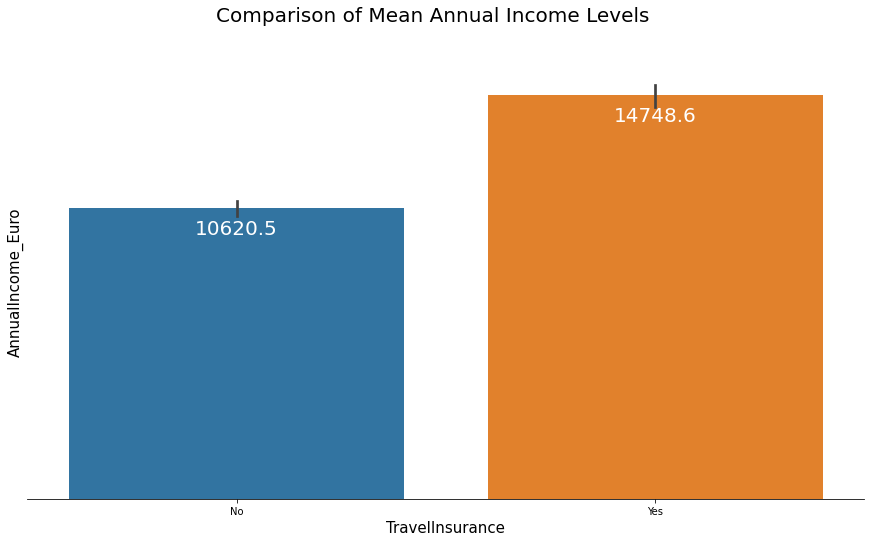

In [387]:
bar_compare(x='TravelInsurance', y='AnnualIncome_Euro',
           tick_labels=['No', 'Yes'], title='Comparison of Mean Annual Income Levels')

People with insurance have largely higher average income level. Average income level for people with insurance is around 14000 Euros. People without insurance have lower average income than the overall average of the dataset. This points out an important insight. People with higher incomes prefer more often to buy insurance. 

We also want to see the relationship between high income and travelling abroad. Before we suspected that those who travelled abroad before may have higher income levels. Let's investigate this.

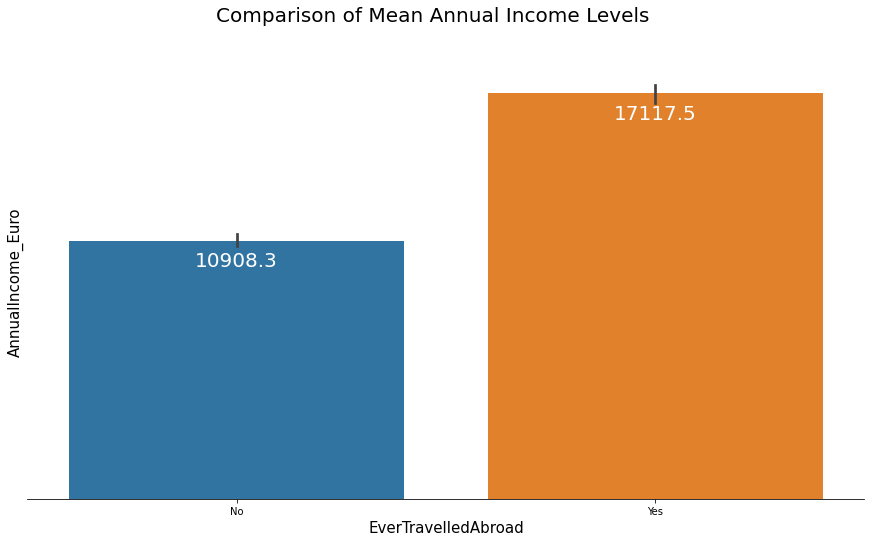

In [388]:
bar_compare(x='EverTravelledAbroad', y='AnnualIncome_Euro',
           tick_labels=['No', 'Yes'], title='Comparison of Mean Annual Income Levels')

There is a clear distinction between people who have travelled abroad and those who have not in terms of income level. Those who have travelled abroad have a higher average income by around 7000 Euros.

The income level we see for individuals that has never travelled abroad is very similar to those without travel insurance. However, for those who have travelled abroad the average income level is much higher. We already know that those who have experience travelling abroad are more likely to get a travel insurance. 

In short, we see that people who travel abroad are better off than others, and they may be more likely to buy a travel insurance.

However, income may not be the only determining factor in an individual's preference of insurances. Education may play a factor in this. Perhaps more educated people are more likely to get insured. Let's see if this is true next.

## Education

Let's start by checking the number of indivduals with an education of graduate level.

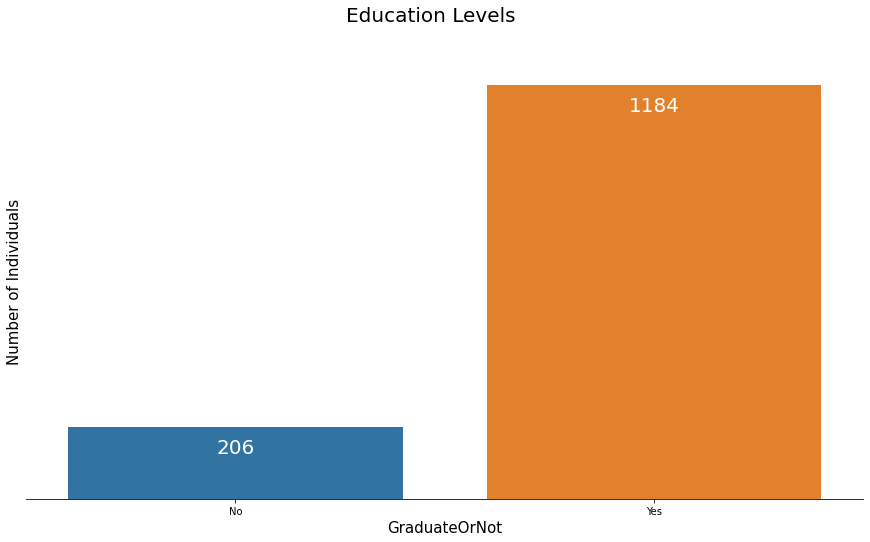

In [389]:
count_plots(x_col='GraduateOrNot',tick_labels=['No','Yes'],
           title='Education Levels')

People with higher education are the clear majority in this dataset. However, we should note here that this dataset is not the whole representation of the population of India. We have seen this distinction when we checked the income levels. Since overwhelming majority of people in this dataset have graduate level education, this feature may not be very good at determining the preference towards travel insurances.

Now let's see how education levels play a role in travel insurances.

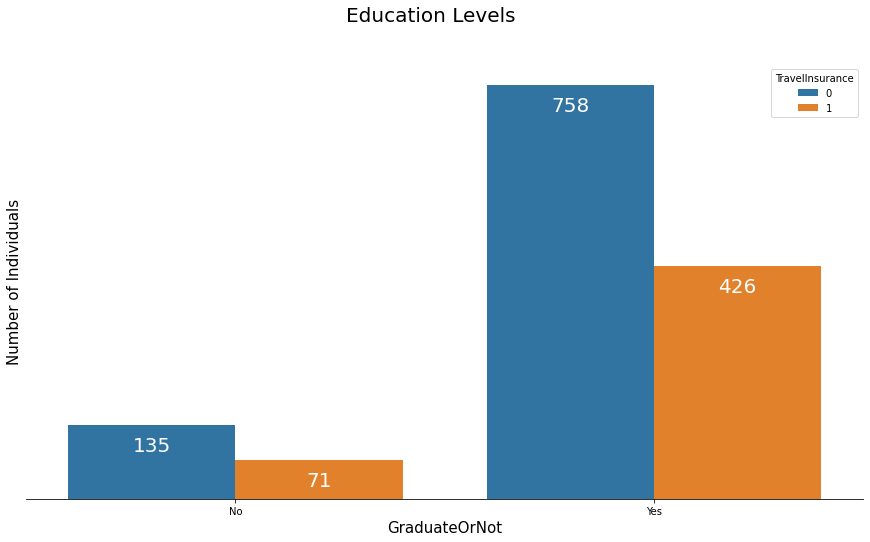

In [390]:
count_plots(x_col='GraduateOrNot',tick_labels=['No','Yes'],
           title='Education Levels', hue_col='TravelInsurance')

For people with graduate degrees and for people without one, the figures seem to follow similar ratios. In both cases, people with travel insurances are half as many people as those without one. It looks like graduate level may not be a good determining factor when predicting travel insurance.

We will now look at another factor: age.

## Age

There may be a difference between younger and older people when it comes to travel insurances. Let's first look at the age distribution in our dataset to understand our demographics better. Then we will graph this against travel insurances to see if there is an actual difference between different ages. 

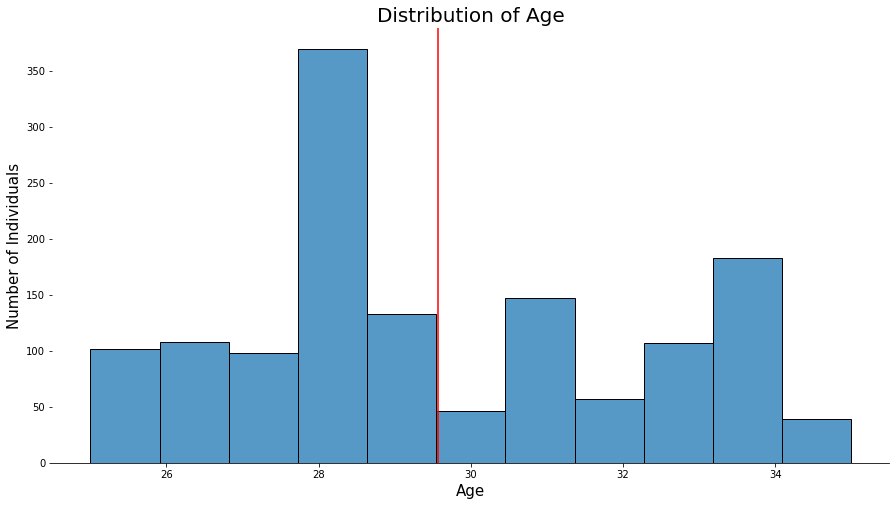

In [391]:
dist_plots('Age', bins=11)

All individuals in this dataset seem to be on the younger side. Most individuals are around the age of 28 and the mean age is around 29. There is not much of an age gap in this dataset. But we will still check the mean age for each insurance category.

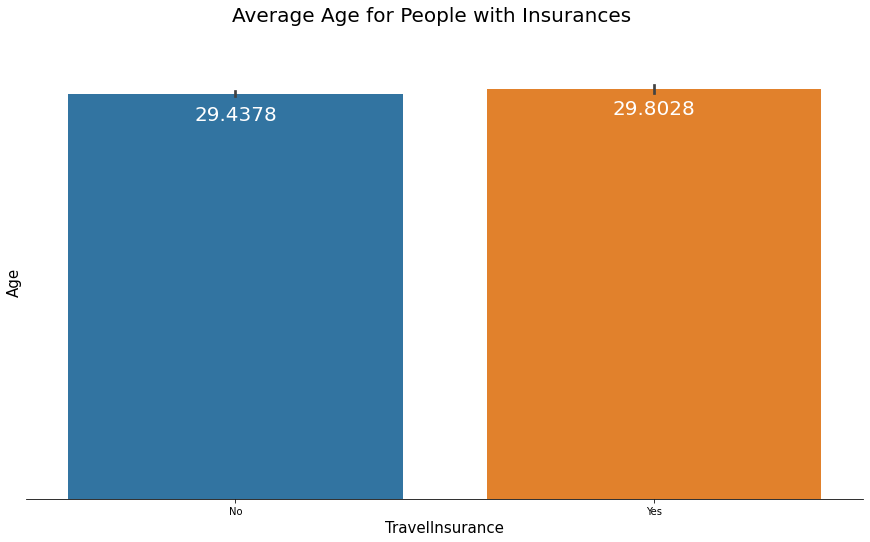

In [392]:
bar_compare(x='TravelInsurance', y='Age',
            title='Average Age for People with Insurances',
           tick_labels=['No', 'Yes'])

Mean age for those who have travel insurance is only slightly higher than those without one. The difference does not seem to be significant, and since age is limited in this dataset, this may not be a good determining factor at predicting travel insurance. 

However, since the mean levels are very similar, we will conduct a hypothesis test to see the statistical significance of the difference.

Considering all individuals in the dataset, do people with a travel insurance have a higher age on average than those without one?

**Population**: All individuals

**Significance Level**: 0.05

**Parameter of Interest**: $\mu_1 - \mu_2$,  Difference of mean age

**Null Hypothesis**: $\mu_1 = \mu_2$

**Alternative Hypothesis**: $\mu_1 > \mu_2$

In [393]:
with_insurance = travel_train['TravelInsurance'] == 1

In [394]:
test_stat, p_value = statsmodels.stats.weightstats.ztest(travel_train.loc[with_insurance, 'Age'],
                                                         travel_train.loc[~with_insurance, 'Age'],
                                                         alternative='larger')
print(f"Test statistic: {test_stat}\n\
p-value: {p_value}")

Test statistic: 2.245021131789497
p-value: 0.012383388002836235


In order to compare these two groups, namely people with and without travel insurances, we decided to look at the difference of their mean age. We have seen before that people with a travel insurance tend to have a slighltly higher age than those without one. In order to test this, we defined an alternative hypothesis which states this assumption. 

The test result returns a very low p-value, which shows us enough evidence to reject the null hypothesis. The null hypothesis states that there is no significant difference between these two groups. As we have rejected this, we will accept that those with an insurance tend to have slightly higher average age than those without one. 

We have found a small difference but it still could have a benefit on our model.

## Other Factors

There may be other factors that are related to the preference of a customer about travel insurances. Let's go over them and see if they actually have a relationship.

### Family Size

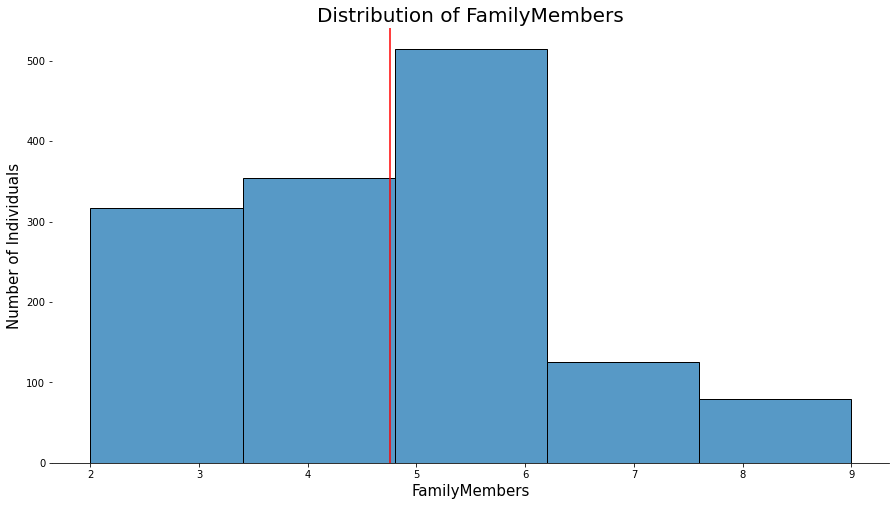

In [395]:
dist_plots('FamilyMembers', bins=5)

In this dataset, very large families seem to be the majority. An average family has around 5 members. The values seem high for the western standards, but these may be the expected values in India. 

Next, we will see average family members for each travel insurance category. Essentialy, these two features may look irrelevant but it may still show us some insight.

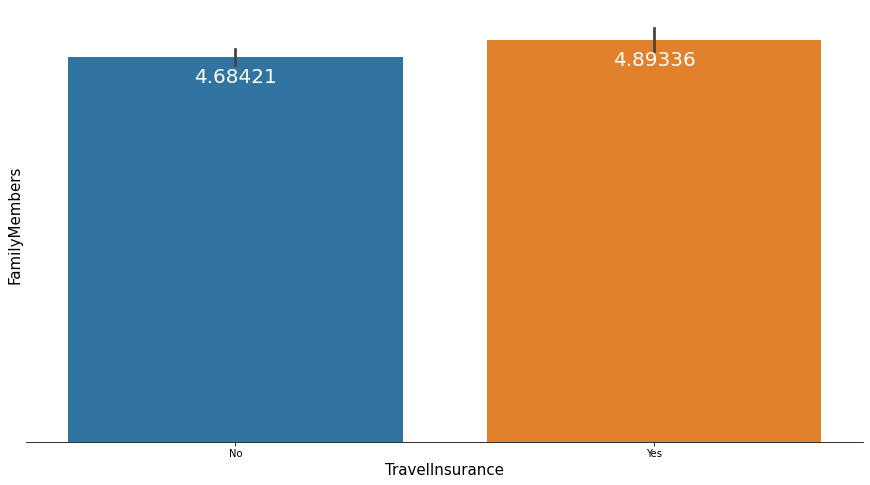

In [396]:
bar_compare(x='TravelInsurance', y='FamilyMembers',
           title='',
           tick_labels=['No', 'Yes'])

People with insurance do not seem to have different number of family members from those who do not have insurance. Although the value is slightly higher for those who have insurance, the difference may not be significant. Let's test this with a hypothesis test.

Considering all individuals in the dataset, do people with a travel insurance have a higher number of family members on average than those without one?

**Population**: All individuals

**Significance Level**: 0.05

**Parameter of Interest**: $\mu_1 - \mu_2$,  Difference of mean family members

**Null Hypothesis**: $\mu_1 = \mu_2$

**Alternative Hypothesis**: $\mu_1 > \mu_2$

In [397]:
test_stat, p_value = statsmodels.stats.weightstats.ztest(travel_train.loc[with_insurance, 'FamilyMembers'],
                                                         travel_train.loc[~with_insurance, 'FamilyMembers'],
                                                         alternative='larger')
print(f"Test statistic: {test_stat}\n\
p-value: {p_value}")

Test statistic: 2.3500469077137836
p-value: 0.009385522670993683


In our test result, we have ended up with a really small p-value. This is smaller than the significance level we have set. This means that, there is enough evidence to say that individuals with travel insurance tend to have a larger family on average than those without one.

This is again an important insight, we could help us improve our machine learning model.

### Chronic Diseases

Travellers with chronic diseases may want to stay on the safe side and buy a travel insurance in case of an emergency. In this part we will see if that is true. Let's first check the distribution of people with chronic diseases.

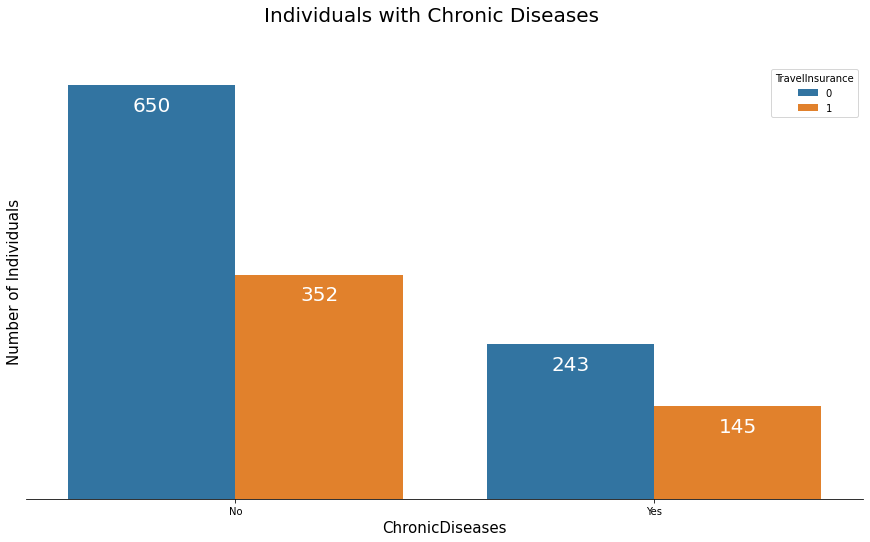

In [398]:
count_plots(x_col='ChronicDiseases', hue_col='TravelInsurance',
           title='Individuals with Chronic Diseases',
            tick_labels=['No', 'Yes'])

Although the people with chronic diseases are in the minority, they are still represented in high numbers in this dataset. Out of this group of individuals, those with travel insurances do not constitute a majority. Most people with chronicle illnesses do not have any travel insurances. A little bit more than half of this amount had a travel insurance. The ratio for those who do not have any chronic diseases is about the same. In this case, chronic diseases may not tell us a lot about an individual's preference over travel insurances. 

### Employment Type

There are two types of employment registered in this dataset. Let's look at how many individuals falls into each category. 

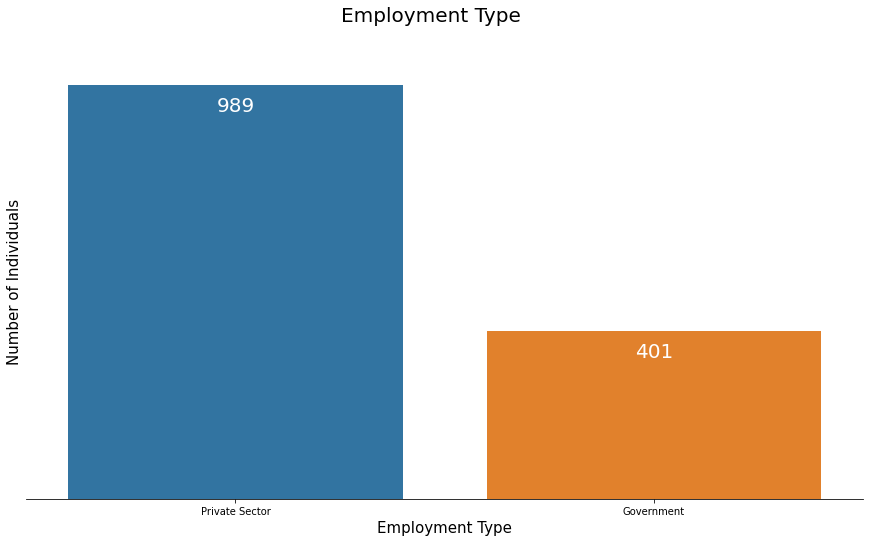

In [399]:
count_plots(x_col='Employment Type', title='Employment Type', tick_labels=['Private Sector', 'Government'])

Most people are employed in private sectors. Government workers are the minority. Perhaps there is a difference between these two groups in terms of travel insurances. Let's check it.

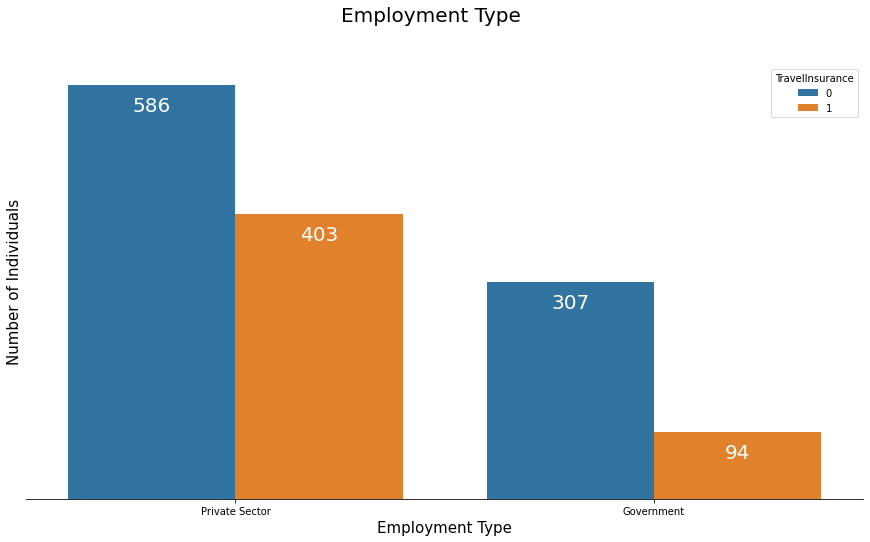

In [400]:
count_plots(x_col='Employment Type', title='Employment Type',
            tick_labels=['Private Sector', 'Government'],
           hue_col='TravelInsurance')

Private sector workers tend to get a travel insurance more than government workers. In government sector, people without a travel insurance constitutes an overwhelming majority. While on the private sector side, we see that people with and without travel insurances have much closer ratios. This insight may be useful in our prediction model.

## Correlation

Finally, let's look at the correlation between features to see a broader picture about our features.

In [401]:
cat_cols = ['Employment Type', 'GraduateOrNot', 'FrequentFlyer', 'EverTravelledAbroad']

for i in cat_cols:
    travel_train[i] = pd.Categorical(travel_train[i])
    travel_train[i] = travel_train[i].cat.codes

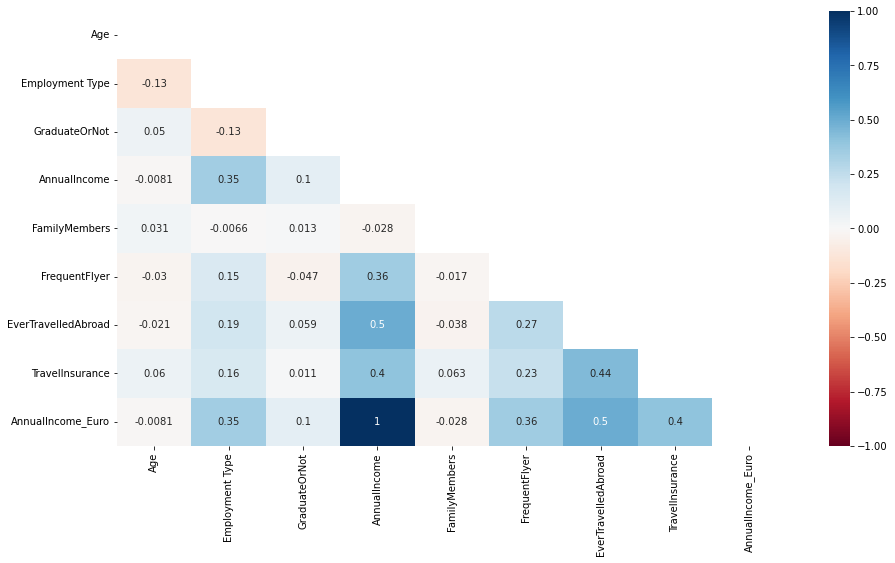

In [402]:
fig, ax = plt.subplots(figsize=(15,8))

mask = np.triu(np.ones_like(travel_train.corr(), dtype='bool'))

sns.heatmap(travel_train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()

It looks like annual income and ever travelled abroad columns have the most strong relationship with our target column. The relationships are not highly strong, but they may be good sources of knowledge for our model.

For other columns, the strongest relationship is between annual income and ever travelled abroad. We have shown this relationship before in the analysis. Let's now move on to create our model. 

## Summary

As we peeked into the data, we have gained some important insights. In the first section, we decided to take a closer look at travellers. We have discovered that there are more people without a travel insurance than those with one. As this is our target feature, we can say that this dataset is not absolutely balanced. However, the difference is not so stark that we needed to balance the categories. 

After this step, we took a look at the individuals who were frequent travellers. Frequent travellers were a minority in this dataset. However, we have found out that frequent travellers were likely to buy a travel insurance. 

We assumed that people who had ever travelled abroad would be likely to buy a travel insurance. We have confirmed this assumption as the data showed that people who had an overseas travel experience were very likely to buy an insurance. The difference was even higher for those who had visited a foreign country and at the same time were frequent flyers. 

In the next section, we have looked at different income levels. We have seen that even the lowest income in this dataset was higher than the average of India. This was an important insight as we have realized that this dataset may not be a good representation of the population of India. Here we discovered that individuals with a travel insurance had a much higher average income. We also checked the income levels of individuals who had an overseas experience and this group had an even higher average income.

Education levels were indicated by whether individuals had a graduate level education or not. We have discovered that most people had a graduate level education. As we have discovered before, this dataset may not be a good representation of the whole population. The ratio of the people who bought a travel insurance were around the same for those with graduate level education and for those without one.

Later, we have looked into age of the individuals. The range of age in this dataset was limited to represent only young people. As before, we have noted that this dataset was not a good representation of the whole market. We have discovered that there was a small difference between individuals with insurance and those without one, in terms of average age. We have confirmed with a hypothesis test that individuals with an insurance tend to be slightly older. 

In this dataset, we have discovered that an average family included around 5 individuals. This is a high number, but we should note here that this may be the expected value for the Indian society. It is dangerous to approach this with western thinking. Finally, we have discovered here that individuals with a travel insurance had more individuals in their families. The difference was confirmed with a hypothesis test. 

We also looked at the people who had a chronic disease. We suspected that this group of people may want to buy a travel insurance. Those who bought an insurance did not constitute a majority in this group, however they were more likely to get one than those without a chronic disease. 

In the end, we have checked the sectors that different individuals worked in. We have realized that most people were working in private sector, and this group was more likely to buy an insurance than those who worked in government. 

These insights were important, and we will use them to make decisions in our feature selection step.

# Travel Insurance Prediction Model

## Feature Engineering

In [403]:
def bin_cats(dataset):
    dataset['Age_binned'] = pd.cut(dataset['Age'], bins=5)
    dataset['FamilyMembers_binned'] = pd.cut(dataset['FamilyMembers'], bins=3,
           labels=['Small Family', 'Medium Family', 'Extended Family'])

In [404]:
bin_cats(X_train)

The function transforms different numeric values into categories. We will later test if this improves the model performance.

## Pipeline

In order to automatically scale to new data, we will create a pipeline, so that the transformations we make will be done on the new dataset before making predictions.

In [405]:
def make_preprocessor(data, scaler=True):
    cat_cols = data.select_dtypes(include=['object', 'category']).columns
    num_cols = data.select_dtypes(include=['int']).columns
    
    if scaler == True:
        num_pipe = Pipeline(steps=[
           ('imputer', SimpleImputer(strategy='mean'))
          ,('scaler', StandardScaler())
        ])
    else:
        num_pipe = Pipeline(steps=[
           ('imputer', SimpleImputer(strategy='mean'))
        ])
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        ,('encoder', OneHotEncoder(drop='first'))
        ])
    preprocessor = ColumnTransformer(
       transformers=[
        ('numeric', num_pipe, num_cols)
       ,('categorical', cat_pipe, cat_cols)
        ])
    return preprocessor

We selected categorical and numerical features to feed into their individual pipelines.

For numerical categories, if there are missing values we want to fill them with the mean value. And then we will scale the values. For categorical ones, we want to fill the missing values with the most frequently seen one. They are later turned into numerical format using one hot encoder.

In [406]:
preprocessor = make_preprocessor(X_train)

Final preprocessor is ready to be fed into the final pipeline.

## Simple Models

First, we will fit some simple models to have an idea of which models have good performance with our dataset.

In [407]:
classifiers = [LogisticRegression(), KNeighborsClassifier(),
               SVC(), DecisionTreeClassifier(), 
              GaussianNB()]

In [408]:
def fit_model(classifiers, X_train=X_train, y_train=y_train):
    for i in classifiers:
        pipeline = Pipeline(steps = [
                   ('preprocessor', preprocessor)
                  ,('classifier', i)])
        model = pipeline.fit(X_train, y_train)
        predictions = model.predict(X_train)
        print (i)
        print (f'Train accuracy:{accuracy_score(predictions, y_train)}')
        print (f'Train recall:{recall_score(predictions, y_train)}')
        print (f'Train roc_auc:{roc_auc_score(predictions, y_train)}')
        cv = cross_validate(pipeline, X_train, y_train, cv=5, scoring=['accuracy', 'recall', 'roc_auc'])
        print(i, 'Cross Validation')
        print(pd.DataFrame(cv).mean(axis=0))

In [409]:
fit_model(classifiers)

LogisticRegression()
Train accuracy:0.781294964028777
Train recall:0.7915407854984894
Train roc_auc:0.7848166628153448
LogisticRegression() Cross Validation
fit_time         0.016953
score_time       0.008610
test_accuracy    0.779137
test_recall      0.527071
test_roc_auc     0.767993
dtype: float64
KNeighborsClassifier()
Train accuracy:0.8352517985611511
Train recall:0.8435897435897436
Train roc_auc:0.8377948717948718
KNeighborsClassifier() Cross Validation
fit_time         0.012726
score_time       0.014582
test_accuracy    0.767626
test_recall      0.563313
test_roc_auc     0.767651
dtype: float64
SVC()
Train accuracy:0.8309352517985612
Train recall:0.8898809523809523
Train roc_auc:0.8510125824523358
SVC() Cross Validation
fit_time         0.020305
score_time       0.017931
test_accuracy    0.820863
test_recall      0.587394
test_roc_auc     0.801515
dtype: float64
DecisionTreeClassifier()
Train accuracy:0.9280575539568345
Train recall:0.9783132530120482
Train roc_auc:0.94248995983

All simple models performed better on training set rather than validation set. This could be a sign of overfitting. Later we will try to fix this by using penalties. 

For now, we will try to select the best models. For our purposes, we selected recall score as our target. We will evaluate the scores regarding to recall, accuracy and roc auc score. 

Support Vector Machine model seems to have the highest accuracy. However, in terms of recall, Decision Tree Classifier has a better score. KNN also has a close enough score in recall. We will keep these three models at hand and try to make an ensemble model out of them.

## Feature Selection

In this section, we will use a Random Forest model to see which features are carrying the most importance. We will also use the insight we have extracted before to make a decision about feature selection.

In [410]:
processor = make_preprocessor(X_train)

In [411]:
X_train_new = preprocessor.fit_transform(X_train)
rf = RandomForestClassifier()
rf.fit(X_train_new, y_train)

RandomForestClassifier()

In [412]:
cat_col_names = preprocessor.transformers_[1][1]\
   .named_steps['encoder'].get_feature_names_out()

In [413]:
col_names = ['Age', 'AnnualIncome', 'FamilyMembers'] + list(cat_col_names)

In [414]:
pd.DataFrame(index=col_names, data=rf.feature_importances_).sort_values(0, ascending=False)

,0
AnnualIncome,0.411055
FamilyMembers,0.137440
x4_Yes,0.101902
Age,0.101544
x2_1,0.052166
x3_Yes,0.048163
x0_Private Sector/Self Employed,0.028496
"x5_(33.0, 35.0]",0.023792
"x5_(27.0, 29.0]",0.021454
x6_Small Family,0.019909


In the random forest model, annual income had the most importance, followed by family members. Following categories look similar to what we have found to be relevant in our analysis. We will now try to subset the dataset and fit a new model.

In [415]:
cv = cross_validate(DecisionTreeClassifier(),
                    pd.get_dummies(X_train[['AnnualIncome', 'FamilyMembers',
                                            'FrequentFlyer', 'EverTravelledAbroad']],
                                   drop_first=True), y_train,
                    cv=5, scoring=['accuracy', 'recall', 'roc_auc'])
print('Cross Validation')
print(pd.DataFrame(cv).mean(axis=0))

Cross Validation
fit_time         0.001220
score_time       0.001693
test_accuracy    0.764029
test_recall      0.535273
test_roc_auc     0.720133
dtype: float64


The features we have chosen have led to a decrease in model performance. We won't be eliminating any features for this model. Let's see whether the binned features we created bring any improvement to the model.

In [416]:
def compare_improvement(cols):
    for i in cols:
        cv = cross_validate(DecisionTreeClassifier(),
                        pd.get_dummies(X_train.drop(i, axis=1),
                                       drop_first=True), y_train,
                        cv=5, scoring=['accuracy', 'recall', 'roc_auc'])
        print(f'Cross Validation without {i}')
        print(pd.DataFrame(cv).mean(axis=0))
        
        cv = cross_validate(DecisionTreeClassifier(),
                        pd.get_dummies(X_train.drop(f'{i}_binned', axis=1),
                                       drop_first=True), y_train,
                        cv=5, scoring=['accuracy', 'recall', 'roc_auc'])
        print(f'Cross Validation without {i}_binned')
        print(pd.DataFrame(cv).mean(axis=0))
        
        cv = cross_validate(DecisionTreeClassifier(),
                        pd.get_dummies(X_train,
                                       drop_first=True), y_train,
                        cv=5, scoring=['accuracy', 'recall', 'roc_auc'])
        print(f'Cross Validation with both')
        print(pd.DataFrame(cv).mean(axis=0))

In [417]:
compare_improvement(['Age', 'FamilyMembers'])

Cross Validation without Age
fit_time         0.001783
score_time       0.001530
test_accuracy    0.763309
test_recall      0.591636
test_roc_auc     0.739311
dtype: float64
Cross Validation without Age_binned
fit_time         0.001670
score_time       0.001360
test_accuracy    0.765468
test_recall      0.613616
test_roc_auc     0.745266
dtype: float64
Cross Validation with both
fit_time         0.001837
score_time       0.001406
test_accuracy    0.769065
test_recall      0.611556
test_roc_auc     0.748034
dtype: float64
Cross Validation without FamilyMembers
fit_time         0.001650
score_time       0.001458
test_accuracy    0.774101
test_recall      0.597515
test_roc_auc     0.755582
dtype: float64
Cross Validation without FamilyMembers_binned
fit_time         0.001785
score_time       0.001455
test_accuracy    0.766906
test_recall      0.607616
test_roc_auc     0.747231
dtype: float64
Cross Validation with both
fit_time         0.001893
score_time       0.001487
test_accuracy    0.

In all cases, we have seen that keeping only the binned features led to a worse performance in recall. However, keeping both together seems to improve the score slightly. We will keep all features.

## Ensemble Models

In this section, we will try different ensemble models to see which one is performing the best. We will check if they perform better than individual models, and if so, we will move on to the next step with the best one.

In [418]:
preprocessor = make_preprocessor(X_train, scaler=True)

In [419]:
vt = VotingClassifier(
    estimators=[('svc', SVC(probability=True)), ('tree', DecisionTreeClassifier()),
               ('kn', KNeighborsClassifier())], voting='soft')
fit_model([vt], X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(probability=True)),
                             ('tree', DecisionTreeClassifier()),
                             ('kn', KNeighborsClassifier())],
                 voting='soft')
Train accuracy:0.8863309352517985
Train recall:0.9335038363171355
Train roc_auc:0.9006858520925016
VotingClassifier(estimators=[('svc', SVC(probability=True)),
                             ('tree', DecisionTreeClassifier()),
                             ('kn', KNeighborsClassifier())],
                 voting='soft') Cross Validation
fit_time         0.089039
score_time       0.019907
test_accuracy    0.800000
test_recall      0.615616
test_roc_auc     0.803233
dtype: float64


In [420]:
preprocessor = make_preprocessor(X_train, scaler=False)

In [421]:
rf = RandomForestClassifier()
fit_model([rf], X_train, y_train)

RandomForestClassifier()
Train accuracy:0.9280575539568345
Train recall:0.9584295612009238
Train roc_auc:0.9363725653444536
RandomForestClassifier() Cross Validation
fit_time         0.073529
score_time       0.014995
test_accuracy    0.793525
test_recall      0.631636
test_roc_auc     0.799212
dtype: float64


In [422]:
ada = AdaBoostClassifier()
fit_model([ada], X_train, y_train)

AdaBoostClassifier()
Train accuracy:0.8100719424460432
Train recall:0.9236363636363636
Train roc_auc:0.8528495719527109
AdaBoostClassifier() Cross Validation
fit_time         0.035670
score_time       0.009762
test_accuracy    0.807914
test_recall      0.520929
test_roc_auc     0.786320
dtype: float64


In [423]:
gra = GradientBoostingClassifier()
fit_model([gra], X_train, y_train)

GradientBoostingClassifier()
Train accuracy:0.8453237410071942
Train recall:0.9325153374233128
Train roc_auc:0.8755621799898519
GradientBoostingClassifier() Cross Validation
fit_time         0.065413
score_time       0.006855
test_accuracy    0.835971
test_recall      0.589394
test_roc_auc     0.812043
dtype: float64


Random forest model outperformed all other models in recall. It also has comparable performance in accuracy and roc auc scores.  As recall is relevant to our case, we will move on with random forest classifier. We will try to improve this model with hyperparameter tuning.

## Fine Tuning

In [424]:
preprocessor = make_preprocessor(X_train, scaler=False)

In [425]:
params = {'rf__n_estimators': np.arange(10, 1000, 50),
         'rf__min_samples_split': np.arange(2, 10, 1),
         'rf__min_samples_leaf': np.arange(1, 6, 1),
          'rf__criterion': ['gini', 'entropy', 'log_loss'],
          'rf__max_features': ['sqrt', 'log2', None],
          'rf__class_weight': ['balanced', 'balanced_subsample', None]
         }

pipeline = Pipeline(steps = [
                   ('preprocessor', preprocessor)
                  ,('rf', RandomForestClassifier(random_state=42))])

search = RandomizedSearchCV(estimator=pipeline, cv=10,
                            n_iter=150 ,param_distributions=params,
                            n_jobs=-1, scoring='recall')

In [426]:
search.fit(X_train, y_train)

RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               Index(['Age', 'AnnualIncome', 'FamilyMembers'], dtype='object')),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
        

In [427]:
pd.DataFrame(search.cv_results_).sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,param_rf__min_samples_split,param_rf__min_samples_leaf,param_rf__max_features,param_rf__criterion,param_rf__class_weight,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
12,0.034596,0.005754,0.006433,0.003752,10,9,2,None,entropy,balanced,...,0.66,0.68,0.7,0.68,0.68,0.62,0.76,0.675959,0.039323,1
13,2.059670,0.123383,0.063063,0.009846,860,4,2,None,gini,balanced_subsample,...,0.64,0.68,0.7,0.70,0.70,0.60,0.72,0.671959,0.046522,2
115,1.150064,0.022242,0.039505,0.002426,610,3,2,None,gini,balanced,...,0.64,0.68,0.7,0.68,0.68,0.62,0.72,0.667918,0.039261,3
34,0.372533,0.016346,0.014829,0.003365,160,2,2,None,entropy,balanced,...,0.64,0.68,0.7,0.68,0.68,0.60,0.72,0.661837,0.041119,4
58,0.515602,0.026169,0.017033,0.003098,210,2,2,None,entropy,balanced_subsample,...,0.64,0.68,0.7,0.68,0.68,0.62,0.72,0.661796,0.045395,5
70,0.214990,0.020756,0.010753,0.003337,110,3,2,None,gini,balanced,...,0.66,0.68,0.7,0.62,0.68,0.60,0.72,0.657837,0.042065,6
11,1.683343,0.066504,0.045803,0.006147,710,2,3,None,entropy,balanced_subsample,...,0.64,0.68,0.7,0.64,0.68,0.62,0.72,0.655755,0.048639,7
10,2.185673,0.058225,0.058989,0.003162,910,6,3,None,entropy,balanced_subsample,...,0.64,0.66,0.7,0.64,0.68,0.62,0.72,0.653755,0.048008,8
9,0.342816,0.024963,0.015150,0.005043,160,8,3,None,gini,balanced,...,0.62,0.68,0.7,0.64,0.66,0.60,0.72,0.651796,0.048579,9
28,1.916377,0.023817,0.052330,0.004872,860,9,2,None,entropy,balanced_subsample,...,0.64,0.66,0.7,0.64,0.68,0.60,0.72,0.651755,0.049758,10


With randomized search, we have tested different hyperparameters, and the best model returned 0.68 recall score. This means that on average, this model was able to detect 68 percent of all people with a travel insurance. We will move on with this model and see how it performs on the training set.

In [431]:
predictions = search.predict(X_train)
print (f'Train roc_auc:{roc_auc_score(predictions, y_train)}')
print (f'Train recall:{recall_score(predictions, y_train)}')
print (f'Train accuracy:{accuracy_score(predictions, y_train)}')

Train roc_auc:0.8799457223839731
Train recall:0.880184331797235
Train accuracy:0.8798561151079136


The model is showing higher scores on the training set. It may be overfitting on the training set. However, the differences are not too dramatic. The model may work well on the test data.

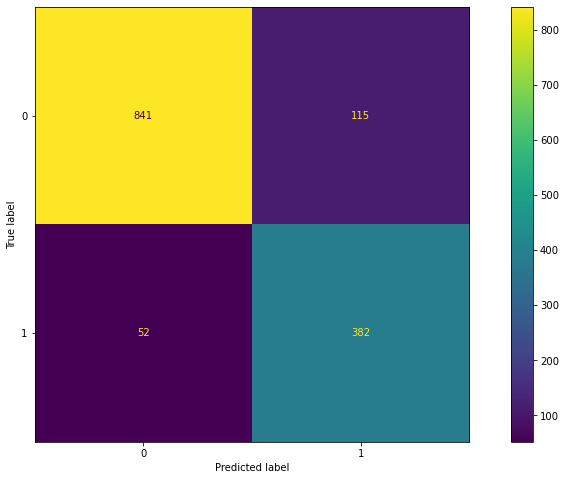

In [447]:
fig, ax = plt.subplots(figsize=(15, 8))
ConfusionMatrixDisplay.from_predictions(predictions, y_train, ax=ax)
plt.show()

Confusion matrix shows that the model was able to identify 382 individuals with travel insurances correctly. However, it missed 52 people. This is not a bad job. However, this is only the results on the training data. We will need to evaluate the same on the test data.

In [433]:
bin_cats(X_test)

In [437]:
y_pred = search.predict(X_test)

In [441]:
print (f'Train roc_auc:{roc_auc_score(y_pred, y_test)}')
print (f'Train recall:{recall_score(y_pred, y_test)}')
print (f'Train accuracy:{accuracy_score(y_pred, y_test)}')

Train roc_auc:0.7853114478114478
Train recall:0.7696969696969697
Train accuracy:0.7922948073701842


The model performs relatively well on the test data. The results are not as good as the training data, however they are still good for our case. Let's take a closer look.

In [439]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       432
           1       0.60      0.77      0.67       165

    accuracy                           0.79       597
   macro avg       0.75      0.79      0.76       597
weighted avg       0.82      0.79      0.80       597



The model has a 79% accuracy. In our case, we wanted to know the people who are likely to get a travel insurance. Our model was able to identify 77% of these people correctly. This is a good score, as we don't mind sending ads to people who are not likely to get an insurance. And according to our result, the people we will send ads are very likely to be someone who would get an insurance.

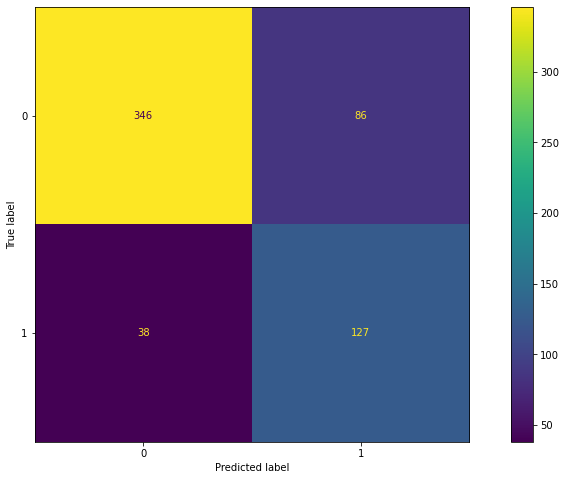

In [440]:
fig, ax = plt.subplots(figsize=(15, 8))
ConfusionMatrixDisplay.from_predictions(y_pred, y_test, ax=ax)
plt.show()

This graph shows that we were able to detect 127 people with travel insurance correctly. We have missed 38 people. We have also detected 83 people incorrectly. However, we want to reach as many people as possible who would be likely to get a travel insurance, and we don't mind reaching those who wouldn't want one. 

# Results

We have checked several different models on our validation set. Out of the models that we have tested, Support Vector Machines, Decision Trees and KNN models were the best performing ones. Decision Trees had the best performance in recall score, which was relevant in our case. 

In order to improve our model performance, we have tested the insights that we have gained in EDA. In this section, we have realized that when we removed the features that we deemed less relevant, the model performance dropped. Finally, we have checked whether the new features we have created would improve the performance. We decided to keep all features at this step.

In order to see if ensemble models would result in better performance, we have checked several different ensemble models. Namely, voting classifier, random forest, adaboost and gradient boost. We fit the voting classifier with the best performing models we have tested before. We scaled the features for voting classifier, and kept them as they are for other tree based ensemble models. As a result, random forest model outperformed others. We have decided work further on random forest model. 

In order to improve our model, we have decided to work on hyperparameters of our model. We created a search space with some possible hyperparameters, and tested. Finally we came up with a model, which resulted in 68% recall score on the validation data.

At the end, we tested the model performance with the test data. The model was able to correctly identify 77% of all individuals with a travel insurance. For our case, we wanted to reach as many people as possible who would be likely to get a travel insurance. This score is adequate for our use case. We will be able to identify about 77% of people who want to get a travel insurance.

# Next Steps

Since we have a complete model, the first next step is to launch the model and identify the individuals who would want to buy an insurance. With this information, we can send them relevant ads and attract them.

We had a small dataset at hand. As a result of this, the model was able to only learn the examples contained in this limited space. In order to generalize better, we may need to collect more data and learn more about the customers.